In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import autojit

这个模型用来模拟音乐分类算法中拆分再集成思想的正确率提升效果。对于拆分后的音乐，每一段的分类准确度可以假设为仅与其上一段和下一段相关，并且当分割的次数越多的时候，这个相关的变化值会越小，因为时间上更接近。所以对音乐分类的正确率作一个假设，取一个音乐片段，30s的，然后分割成若干份，从之前的实验结果中可以假设拆分后的片段的平均正确率与未拆分大致相近，这里就假设为一样了。只对这个片段而言，取分割的第一个小片段随机出一个值，和原来的p比价大小得到这个片段的分类到正确与否。用最简单的方法，01均匀随机变量，如果变量小于p，则分类正确。如果大于p，则要考虑分类成其他种类的情况，这里并不是只分成了另外一类，或者是平均随机到另外一类中。在现实情况中，容易存在另一个分类与这个分类高度相关，会有很大概率被分成这个组，而且还会有一些种类高度不相关，以很小的可能性被错误的分到这组。所以我假设在错误的情况下有50%概率分为这个组，同时还有第二相关分类，设为25%概率，剩下的25%由其他种类评分。最后每个小片段得到了自己的分类，通过投票取最多的方式得到大片段的分类。以上的全部步骤称为一次判断，所得到的最终结果只返回正确或者错误，这里的正确就是被正确分类，但错误是被分为其他任何一类。对这样的周期运算足够多次后，可以趋于正确率，用这个正确率代表拆分再集成后的正确率，和原来的正确率比较，画图，可以看到结果。我尝试过多种系数，其趋势都是一致的，仅存在一个过零点，初始正确率在之下，集成会变低，而在之上会变高。这个过零点的值以及图像的一二阶导数与系数选取高度相关，目前我找的算是比较符合实际验证的结果。这个模型的存在意义就是计算速度足够快，如果只是用提取特征再计算的方式画图，一天只能描出8个点左右。系数选取应该不重要，有趋势就可以证明这个集成方法有用了。纯用理论假设的方式，矩阵等计算不仅假设相关系数，还要有联合分布等，很难做出来。

In [38]:
#分割的份数
n = 12
#音乐分类种类
m = 10
#未被分割时，分类正确的概率
p = 0.5
#重复次数
N = 100000

In [51]:
@autojit(nopython=True)
def accuracy(n,m,p,N):
    #right表示N次循环中分类正确的次数
    right = 0
    #做N次减小误差
    for k in range(N):
        #随机数
        random = np.random.rand(2*n)
        #a代表每次选到的概率值
        a = np.zeros(n)
        #up是下次随机取样可能得到的最高值
        up = np.zeros(n)
        #down是下次随机取样可能取到的最低值
        down = np.zeros(n)
        #y_hat是通过a得到的判断值，0是正确，1是错误最高的种类，2是错误第二高的种类，剩下的是其他的。
        y_hat = np.zeros(n)
        #yy_hat是在n分割下被判断成每个种类的次数
        yy_hat = np.zeros(n)
        
        #最开始的值是随机的
        a[0] = random[0]
        for i in range(1,n):
            #做几个系数控制一下，事实上这个模型的正确率和这些系数有很大关系，这里只能随便取了。
            #u系数控制down的取值，d系数控制up的取值
            u = (1-a[i-1])**(1/3)
            d = (a[i-1])**(1/3)
            #下次随机取样最高值的计算方法，按上次值与最高值剩余量的百分比计算
            up[i] = (1-a[i-1])*2/n*d +a[i-1]
            #下次随机取样最低值的计算方法，按上次值与最低值剩余量的百分比计算
            down[i] = a[i-1] - a[i-1]*2/n*u
            #随机得出下一次的取值
            a[i] = random[2*i]*(up[i]-down[i]) + down[i]

        #y_hat的计算方法
        for i in range(n):
            if a[i] < p:
                y_hat[i] = 0
            else:
                for j in range(n):
                    if random[2*i-1] < possible[j]:
                        y_hat[i] = j
                        break

        #yy_hat的计算方法
        for i in range(n):
            for j in range(n):
                if y_hat[i] == j:
                    yy_hat[j] += 1
        
        #取值y的计算方法
        y = np.argmax(yy_hat)
        if y == 0:
            right +=1

        #print(a)
        #print(y_hat)
        #print(yy_hat)
        #print(y)

    #print('正确率',right/N)
    return right/N

In [93]:
m = 10
#模拟真实分类时候的错误，在分类错误的情况下，总有另一个种类特别相近的，所以取50%的错误是那个分类。
#同时可能还有第二相近的，就当做25%。剩下的在剩余概率中平分。
#possible仅与n的取值相关
possible = np.zeros(m)
if n > 3:
    possible[0] = 0
    possible[1] = possible[0]+(1-possible[0])/(math.log10(m)+1)
    possible[2] = possible[1]+(1-possible[1])/(math.log10(m)+1)
    for i in range(3,m):
        possible[i] = possible[2]+(1-possible[2])*(i-2)/(m-3)
if n == 3:
    possible[0] = 0
    possible[1] = possible[0]+(1-possible[0])/(math.log10(m)+1)
    possible[2] = 1
if n == 2 :
    possible[0] = 0
    possible[1] = 1
possible

array([0.        , 0.5       , 0.75      , 0.78571429, 0.82142857,
       0.85714286, 0.89285714, 0.92857143, 0.96428571, 1.        ])

In [105]:
#对p值跑若干次进行画图
n = 12
times = 50
acc1210 = np.zeros(times+1)
x = np.zeros(times+1)

for i in range(1,times+1):
    p = i/times
    x[i] = p
    print(p)
    acc1210[i] = accuracy(n,m,p,N)


0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0


In [95]:
#对p值跑若干次进行画图
n = 60
times = 50
acc6010 = np.zeros(times+1)
x = np.zeros(times+1)

for i in range(1,times+1):
    p = i/times
    x[i] = p
    print(p)
    acc6010[i] = accuracy(n,m,p,N)

0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0


In [96]:
m = 80
#模拟真实分类时候的错误，在分类错误的情况下，总有另一个种类特别相近的，所以取50%的错误是那个分类。
#同时可能还有第二相近的，就当做25%。剩下的在剩余概率中平分。
#possible仅与n的取值相关
possible = np.zeros(m)
if n > 3:
    possible[0] = 0
    possible[1] = possible[0]+(1-possible[0])/(math.log10(m)+1)
    possible[2] = possible[1]+(1-possible[1])/(math.log10(m)+1)
    for i in range(3,m):
        possible[i] = possible[2]+(1-possible[2])*(i-2)/(m-3)
if n == 3:
    possible[0] = 0
    possible[1] = possible[0]+(1-possible[0])/(math.log10(m)+1)
    possible[2] = 1
if n == 2 :
    possible[0] = 0
    possible[1] = 1
possible

array([0.        , 0.34446056, 0.57026804, 0.57584898, 0.58142991,
       0.58701084, 0.59259178, 0.59817271, 0.60375365, 0.60933458,
       0.61491552, 0.62049645, 0.62607739, 0.63165832, 0.63723926,
       0.64282019, 0.64840112, 0.65398206, 0.65956299, 0.66514393,
       0.67072486, 0.6763058 , 0.68188673, 0.68746767, 0.6930486 ,
       0.69862954, 0.70421047, 0.7097914 , 0.71537234, 0.72095327,
       0.72653421, 0.73211514, 0.73769608, 0.74327701, 0.74885795,
       0.75443888, 0.76001982, 0.76560075, 0.77118168, 0.77676262,
       0.78234355, 0.78792449, 0.79350542, 0.79908636, 0.80466729,
       0.81024823, 0.81582916, 0.8214101 , 0.82699103, 0.83257196,
       0.8381529 , 0.84373383, 0.84931477, 0.8548957 , 0.86047664,
       0.86605757, 0.87163851, 0.87721944, 0.88280037, 0.88838131,
       0.89396224, 0.89954318, 0.90512411, 0.91070505, 0.91628598,
       0.92186692, 0.92744785, 0.93302879, 0.93860972, 0.94419065,
       0.94977159, 0.95535252, 0.96093346, 0.96651439, 0.97209

In [97]:
#对p值跑若干次进行画图
n = 12
m = 80
times = 50
acc1280 = np.zeros(times+1)
x = np.zeros(times+1)

for i in range(1,times+1):
    p = i/times
    x[i] = p
    print(p)
    acc1280[i] = accuracy(n,m,p,N)

0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0


In [98]:
#对p值跑若干次进行画图
n = 60
m = 80
times = 50
acc6080 = np.zeros(times+1)
x = np.zeros(times+1)

for i in range(1,times+1):
    p = i/times
    x[i] = p
    print(p)
    acc6080[i] = accuracy(n,m,p,N)

0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0


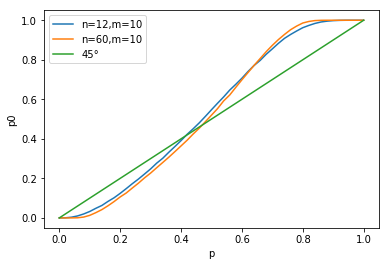

In [99]:
#这个图的横轴是直接分类的准确率，纵轴是经过拆分集成计算的准确率。
plt.plot(x,acc1210,label = 'n=12,m=10')
plt.plot(x,acc6010,label = 'n=60,m=10')
plt.plot(x,x,label = '45°')
plt.legend(['n=12,m=10','n=60,m=10','45°'])
plt.xlabel(u'p')
plt.ylabel(u'p0')
plt.show()

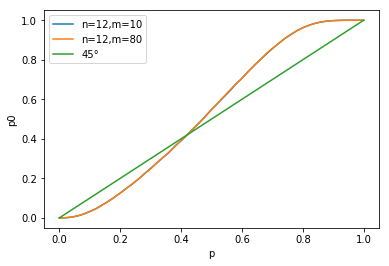

In [106]:
#这个图的横轴是直接分类的准确率，纵轴是经过拆分集成计算的准确率。
plt.plot(x,acc1210,label = 'n=12,m=10')
plt.plot(x,acc1280,label = 'n=12,m=80')
plt.plot(x,x,label = '45°')
plt.legend(['n=12,m=10','n=12,m=80','45°'])
plt.xlabel('p')
plt.ylabel('p0')
plt.show()

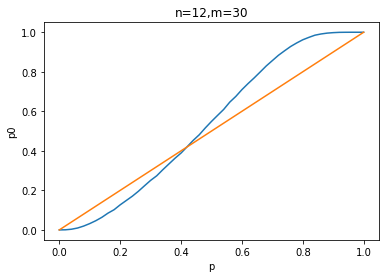

In [101]:
#这个图的横轴是直接分类的准确率，纵轴是经过拆分集成计算的准确率。
plt.plot(x,acc)
plt.plot(x,x)
plt.xlabel('p')
plt.ylabel('p0')
plt.title('n=12,m=30')
plt.show()

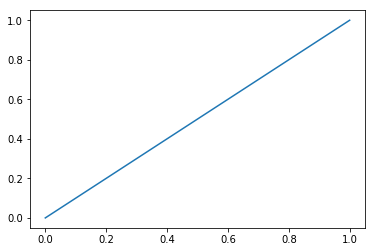

In [102]:
plt.plot(x,x,label = '45°')